# CMIP6 #

Here is a quick example of how to use [`Tracker.track`](https://ocetrac.readthedocs.io/en/latest/_generated/ocetrac.Tracker.track.html#ocetrac.Tracker.track) to detect and track **marine heatwaves** from ocean temperature data available from  CMIP6.

First import numpy, xarray, matplotlib, intake, cmip6_preprocessing, ocetrac, and dask:

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import intake
from cmip6_preprocessing.preprocessing import combined_preprocessing
import ocetrac 
from dask_gateway import Gateway
from dask.distributed import Client
from dask import delayed
import dask
dask.config.set({"array.slicing.split_large_chunks": False});

Start a dask kubernetes cluster:

In [2]:
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt(minimum=1, maximum=20)
client = Client(cluster)
cluster

☝️ Don’t forget to click the dashboard link above to view the scheduler!


### NOAA-GFDL CM4

An Earth System Model collection for CMIP6 Zarr data resides on Pangeo's Google Storage. We will create a query to import data from the historical simulation of monthly ocean surface temperatures provided by the [NOAA-Geophysical Fluid Dynamics Global Climate Model](https://www.gfdl.noaa.gov/coupled-physical-model-cm4/).

In [3]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# create a query dictionary
query = col.search(experiment_id=['historical'], # all forcing of the recent past
                 table_id='Omon', # ocean monthly data
                 source_id='GFDL-CM4', # GFDL Climate Model 4
                 variable_id=['tos'], # temperature ocean surface
                 grid_label='gr', # regridded data on target grid
                )
query

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,1
table_id,1
variable_id,1
grid_label,1
zstore,1
dcpp_init_year,0


In [4]:
ds = query.to_dataset_dict(zarr_kwargs={'consolidated': True},
                           storage_options={'token': 'anon'},
                           preprocess=combined_preprocessing,
                          ) 

tos = ds['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gr'].tos.isel(member_id=0).sel(time=slice('1980', '2014'))
tos


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.DataArray 'tos' (time: 420, y: 180, x: 360)>
dask.array<getitem, shape=(420, 180, 360), dtype=float32, chunksize=(120, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) object 1980-01-16 12:00:00 ... 2014-12-16 12:00:00
    lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    member_id  <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

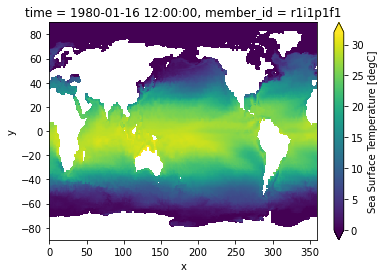

In [5]:
tos.isel(time=0).plot(vmin=0, vmax=32);

Create a binary mask for ocean points:

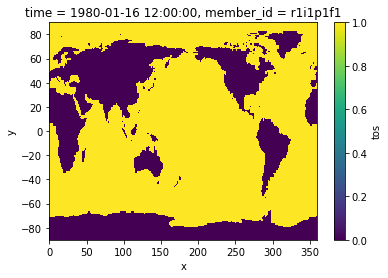

In [6]:
mask_ocean = 1 * np.ones(tos.shape[1:]) * np.isfinite(tos.isel(time=0))  
mask_land = 0 * np.ones(tos.shape[1:]) * np.isnan(tos.isel(time=0))  
mask = mask_ocean + mask_land
mask.plot()

### Preprocesses the Data

We will simply define monthly anomalies by subtracting the monthly climatology averaged across 1980–2014. Anomalies that exceed the monthly 90th percentile will be considered here as extreme. 


In [7]:
climatology = tos.groupby(tos.time.dt.month).mean()
anomaly = tos.groupby(tos.time.dt.month) - climatology

# Rechunk time dim
if tos.chunks:
    tos = tos.chunk({'time': -1})

percentile = .9
threshold = tos.groupby(tos.time.dt.month).quantile(percentile, dim='time', keep_attrs=True, skipna=True)
hot_water = anomaly.groupby(tos.time.dt.month).where(tos.groupby(tos.time.dt.month)>threshold)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 35 times more chunks
  return self.array[key]


In [8]:
%%time
hot_water.load()
client.close()

CPU times: user 653 ms, sys: 165 ms, total: 818 ms
Wall time: 1min 4s


The plots below shows sea surface temperature anomalies averaged for the month of January 1980. The right panel shows only the **extreme** anomalies exceeding the 90th percentile.

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


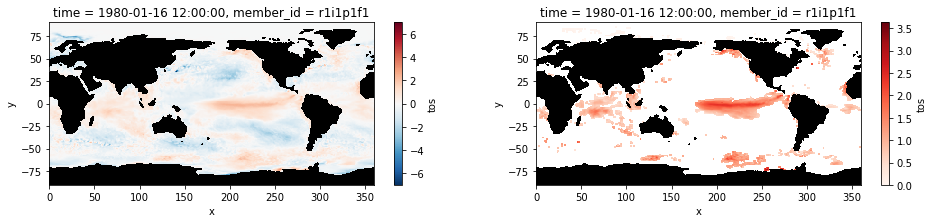

In [9]:
plt.figure(figsize=(16,3))

ax1 = plt.subplot(121);anomaly.isel(time=0).plot(cmap='RdBu_r')
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax1.set_aspect('equal');

ax2 = plt.subplot(122); hot_water.isel(time=0).plot(cmap='Reds', vmin=0);
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax2.set_aspect('equal');

### Run Ocetrac

Using the extreme SST anomalies only, we use Ocetrac to label and track marine heatwave events.

We need to define two key parameters that can be tuned bases on the resolution of the dataset and distribution of data. The first is `radius` which represents the number of grid cells defining the width of the structuring element used in the morphological operations (i.e., opening and closing). The second is `min_size_quartile` that is used as a threshold to subsample the objects accroding the the distribution of object area. 

In [10]:
%%time 
Tracker = ocetrac.Tracker(hot_water, mask, radius=2, min_size_quartile=0.75, timedim = 'time', xdim = 'x', ydim='y', positive=True)
blobs = Tracker.track()

minimum area: 107.0
inital objects identified 	 15682
final objects tracked 	 903
CPU times: user 39.8 s, sys: 1.5 s, total: 41.3 s
Wall time: 41.4 s


**Let's take a look at some of the attributes.**

There were over 15,500 MHW object detected. After connecting these events in time and eliminating objects smaller than the 75th percentle (equivalent to the area of 107 grid cells), 903 total MHWs are identified between 1980–2014. 

In [11]:
blobs.attrs

{'inital objects identified': 15682,
 'final objects tracked': 903,
 'radius': 2,
 'size quantile threshold': 0.75,
 'min area': 107.0,
 'percent area reject': 0.17453639541742397,
 'percent area accept': 0.8254636045825761}

### Visualize Output

Plot the labeled marine heatwaves on January 1980 and compare it to the input image of the preprocessed extreme sea surface temperature anomalies.

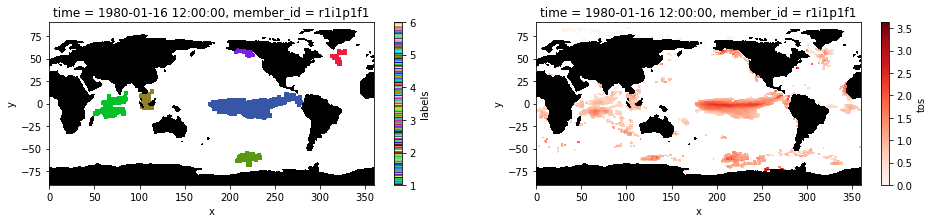

In [12]:
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())

plt.figure(figsize=(16,3))
ax1 = plt.subplot(121);blobs.isel(time=0).plot(cmap= cm)
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax1.set_aspect('equal')
ax2 = plt.subplot(122); hot_water.isel(time=0).plot(cmap='Reds', vmin=0);
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax2.set_aspect('equal');